In [1]:
using ITensors
using Random
using Plots
using Distributions
using PyCall
pyts = pyimport("pyts.approximation");

# Small Scale Log Loss Trial

Create mock data

In [2]:
data = randn(10, 50);
labels = rand([0, 1], 10);

In [3]:
function ZScoredTimeSeriesToSAX(time_series::Matrix; n_bins::Int=3, strategy="normal")
    """Function to convert Z-SCORED time series data to a SAX representation.
    Calls on the SAX library in python using pycall."""

    if strategy !== "normal" && strategy !== "quantile" && strategy !== "uniform"
        error("Invalid SAX strategy. Can be either: `normal', `quantil' or `uniform'.")
    end

    # fit the SAX 'model'
    sax = pyts.SymbolicAggregateApproximation(n_bins=n_bins, strategy=strategy)
    sax_fit = sax.fit(time_series)
    X_sax = sax_fit.transform(time_series)

    # return both the model and the transformed data (as pyobject)
    return X_sax, sax_fit

end;

Encode data using SAX

In [4]:
X_sax, sax_fit = ZScoredTimeSeriesToSAX(data);

Create site indices

In [5]:
sites = siteinds("Qudit", 50; dim=3)

50-element Vector{Index{Int64}}:
 (dim=3|id=212|"Qudit,Site,n=1")
 (dim=3|id=653|"Qudit,Site,n=2")
 (dim=3|id=259|"Qudit,Site,n=3")
 (dim=3|id=274|"Qudit,Site,n=4")
 (dim=3|id=630|"Qudit,Site,n=5")
 (dim=3|id=289|"Qudit,Site,n=6")
 (dim=3|id=513|"Qudit,Site,n=7")
 (dim=3|id=551|"Qudit,Site,n=8")
 (dim=3|id=222|"Qudit,Site,n=9")
 (dim=3|id=748|"Qudit,Site,n=10")
 ⋮
 (dim=3|id=266|"Qudit,Site,n=42")
 (dim=3|id=205|"Qudit,Site,n=43")
 (dim=3|id=666|"Qudit,Site,n=44")
 (dim=3|id=80|"Qudit,Site,n=45")
 (dim=3|id=732|"Qudit,Site,n=46")
 (dim=3|id=166|"Qudit,Site,n=47")
 (dim=3|id=320|"Qudit,Site,n=48")
 (dim=3|id=401|"Qudit,Site,n=49")
 (dim=3|id=798|"Qudit,Site,n=50")

In [6]:
function SAXEncodingToProductState(sax_sample, sites::Vector{Index{Int64}}, 
    sax_encoder::PyObject)
    """Function to map the SAX encodings to a product state |ϕ> where the local
    dimension is determined by the alphabet size for SAX."""

    # check that the local Hilbert space dimension and alphabet size match
    if sax_encoder.n_bins !== ITensors.dim(sites[1])
        error("Alphabet size ($(sax_encoder.n_bins)) not equal to the local Hilbert space 
        dimension ($(ITensors.dim(sites[1])))")
    end

    # check the number of site indices and the length of the SAX-encoded sample match.
    if length(sax_sample) !== length(sites)
        error("Length of the SAX-encoded sample ($(length(sax_sample))) does not match
        the number of sites specified by the site indices ($(length(sites)))")
    end

    # dynamically allocate mappings based on the alphabet size
    alphabet_size = sax_encoder.n_bins
    alphabet = 'a' : 'z'

    # use the mapping conveention where 1 maps to a, b to 2, and so on
    mappings = Dict()
    for (i, letter) in enumerate(alphabet[1:alphabet_size])
        mappings[string(letter)] = i
    end

    # create empty product state container
    ϕ = MPS(sites; linkdims=1)

    # loop through each site and fill tensor with fock state
    for s = 1:length(sites)

        T = ITensor(sites[s])
        letter = sax_sample[s]
        T[mappings[letter]] = 1 # one hot encode, so |a> -> |1> -> [1, 0, 0, ..]
        ϕ[s] = T

    end

    return ϕ

end;

In [7]:
ϕs = [SAXEncodingToProductState(X_sax[i], sites, sax_fit) for i=1:length(X_sax) ]

10-element Vector{MPS}:
 MPS
[1] ((dim=3|id=212|"Qudit,Site,n=1"),)
[2] ((dim=3|id=653|"Qudit,Site,n=2"),)
[3] ((dim=3|id=259|"Qudit,Site,n=3"),)
[4] ((dim=3|id=274|"Qudit,Site,n=4"),)
[5] ((dim=3|id=630|"Qudit,Site,n=5"),)
[6] ((dim=3|id=289|"Qudit,Site,n=6"),)
[7] ((dim=3|id=513|"Qudit,Site,n=7"),)
[8] ((dim=3|id=551|"Qudit,Site,n=8"),)
[9] ((dim=3|id=222|"Qudit,Site,n=9"),)
[10] ((dim=3|id=748|"Qudit,Site,n=10"),)
[11] ((dim=3|id=596|"Qudit,Site,n=11"),)
[12] ((dim=3|id=722|"Qudit,Site,n=12"),)
[13] ((dim=3|id=394|"Qudit,Site,n=13"),)
[14] ((dim=3|id=592|"Qudit,Site,n=14"),)
[15] ((dim=3|id=282|"Qudit,Site,n=15"),)
[16] ((dim=3|id=93|"Qudit,Site,n=16"),)
[17] ((dim=3|id=402|"Qudit,Site,n=17"),)
[18] ((dim=3|id=483|"Qudit,Site,n=18"),)
[19] ((dim=3|id=242|"Qudit,Site,n=19"),)
[20] ((dim=3|id=387|"Qudit,Site,n=20"),)
[21] ((dim=3|id=955|"Qudit,Site,n=21"),)
[22] ((dim=3|id=204|"Qudit,Site,n=22"),)
[23] ((dim=3|id=18|"Qudit,Site,n=23"),)
[24] ((dim=3|id=794|"Qudit,Site,n=24"),)
[25] ((

Create MPS

In [8]:
W = randomMPS(sites; linkdims=5)

MPS
[1] ((dim=3|id=212|"Qudit,Site,n=1"), (dim=5|id=954|"Link,l=1"))
[2] ((dim=5|id=954|"Link,l=1"), (dim=3|id=653|"Qudit,Site,n=2"), (dim=5|id=496|"Link,l=2"))
[3] ((dim=5|id=496|"Link,l=2"), (dim=3|id=259|"Qudit,Site,n=3"), (dim=5|id=864|"Link,l=3"))
[4] ((dim=5|id=864|"Link,l=3"), (dim=3|id=274|"Qudit,Site,n=4"), (dim=5|id=811|"Link,l=4"))
[5] ((dim=5|id=811|"Link,l=4"), (dim=3|id=630|"Qudit,Site,n=5"), (dim=5|id=10|"Link,l=5"))
[6] ((dim=5|id=10|"Link,l=5"), (dim=3|id=289|"Qudit,Site,n=6"), (dim=5|id=794|"Link,l=6"))
[7] ((dim=5|id=794|"Link,l=6"), (dim=3|id=513|"Qudit,Site,n=7"), (dim=5|id=136|"Link,l=7"))
[8] ((dim=5|id=136|"Link,l=7"), (dim=3|id=551|"Qudit,Site,n=8"), (dim=5|id=982|"Link,l=8"))
[9] ((dim=5|id=982|"Link,l=8"), (dim=3|id=222|"Qudit,Site,n=9"), (dim=5|id=162|"Link,l=9"))
[10] ((dim=5|id=162|"Link,l=9"), (dim=3|id=748|"Qudit,Site,n=10"), (dim=5|id=133|"Link,l=10"))
[11] ((dim=5|id=133|"Link,l=10"), (dim=3|id=596|"Qudit,Site,n=11"), (dim=5|id=638|"Link,l=11"))
[12] (

In [9]:
function AttachLabelIndex!(W::MPS, num_classes::Int; attach_site::Int=1)
    """
    Function to attach the decision label index to the un-labelled weight MPS at
    the specified site. Dimension is equal to the number of classes."""
    label_idx = Index(num_classes, "f(x)")

    # get the site of interest and copy over the indices
    old_site_idxs = inds(W[attach_site])
    new_site_idxs = old_site_idxs, label_idx
    new_site = randomITensor(new_site_idxs)

    # add the updated site back into the MPS
    W[attach_site] = new_site

    # normalise the MPS again
    normalize!(W)

end

AttachLabelIndex! (generic function with 1 method)

In [10]:
AttachLabelIndex!(W, 2)

MPS
[1] ((dim=3|id=212|"Qudit,Site,n=1"), (dim=5|id=954|"Link,l=1"), (dim=2|id=513|"f(x)"))
[2] ((dim=5|id=954|"Link,l=1"), (dim=3|id=653|"Qudit,Site,n=2"), (dim=5|id=496|"Link,l=2"))
[3] ((dim=5|id=496|"Link,l=2"), (dim=3|id=259|"Qudit,Site,n=3"), (dim=5|id=864|"Link,l=3"))
[4] ((dim=5|id=864|"Link,l=3"), (dim=3|id=274|"Qudit,Site,n=4"), (dim=5|id=811|"Link,l=4"))
[5] ((dim=5|id=811|"Link,l=4"), (dim=3|id=630|"Qudit,Site,n=5"), (dim=5|id=10|"Link,l=5"))
[6] ((dim=5|id=10|"Link,l=5"), (dim=3|id=289|"Qudit,Site,n=6"), (dim=5|id=794|"Link,l=6"))
[7] ((dim=5|id=794|"Link,l=6"), (dim=3|id=513|"Qudit,Site,n=7"), (dim=5|id=136|"Link,l=7"))
[8] ((dim=5|id=136|"Link,l=7"), (dim=3|id=551|"Qudit,Site,n=8"), (dim=5|id=982|"Link,l=8"))
[9] ((dim=5|id=982|"Link,l=8"), (dim=3|id=222|"Qudit,Site,n=9"), (dim=5|id=162|"Link,l=9"))
[10] ((dim=5|id=162|"Link,l=9"), (dim=3|id=748|"Qudit,Site,n=10"), (dim=5|id=133|"Link,l=10"))
[11] ((dim=5|id=133|"Link,l=10"), (dim=3|id=596|"Qudit,Site,n=11"), (dim=5|id=6

In [11]:
res = 1
for i=1:50
    res *= W[i] * ϕs[1][i]
end

In [12]:
minimum(abs.(vector(res)))

2.379067383452867e-15

In [109]:
T = 10:10:500
D = [2, 3, 5, 8]
overlap_per_d = []
for d in D
    min_overlap_per_t = []
    for t in T
        data = randn(5, t);
        X_sax, sax_fit = ZScoredTimeSeriesToSAX(data; n_bins=d);
        sites = siteinds("Qudit", t; dim=d)
        ϕs = [SAXEncodingToProductState(X_sax[i], sites, sax_fit) for i=1:length(X_sax) ]
        W = randomMPS(sites; linkdims=5)
        AttachLabelIndex!(W, 2)
        res = 1
        for i=1:t
            res *= W[i] * ϕs[1][i]
        end
        min_val = minimum(abs.(vector(res)))
        push!(min_overlap_per_t, min_val)
    end
    push!(overlap_per_d, min_overlap_per_t)
end

In [110]:
overlap_per_d

4-element Vector{Any}:
 Any[0.002830790768315438, 5.843405164878234e-7, 9.908794785297065e-7, 8.045280269394462e-8, 8.57006173614716e-9, 1.551499376825681e-10, 8.483864936492833e-12, 1.43417260452471e-15, 1.6351708708694747e-17, 4.347126241053064e-19  …  1.7705421562636231e-72, 7.288905964289528e-76, 1.7265035918611845e-73, 1.9306840422173277e-79, 2.8709092199977813e-78, 2.0059775198768985e-82, 4.484354017106894e-81, 8.591422839885139e-84, 9.151302057711944e-90, 5.2108526135746736e-92]
 Any[9.853923200673277e-5, 1.778925966310525e-6, 4.798836178290833e-9, 2.2738410199128167e-12, 8.422951113503073e-15, 1.6278115958951362e-17, 6.975473416201608e-21, 1.581117246581747e-22, 1.1900866956635728e-26, 1.9755346647916068e-28  …  1.0252450032181446e-115, 2.561196274208369e-115, 1.5450276051196764e-118, 2.6882461042717682e-117, 1.2365898167659625e-127, 1.1382103805095216e-125, 2.2622269002413235e-130, 7.174422544845553e-132, 2.6529679132184177e-133, 1.9881003187830164e-137]
 Any[4.957639970819046

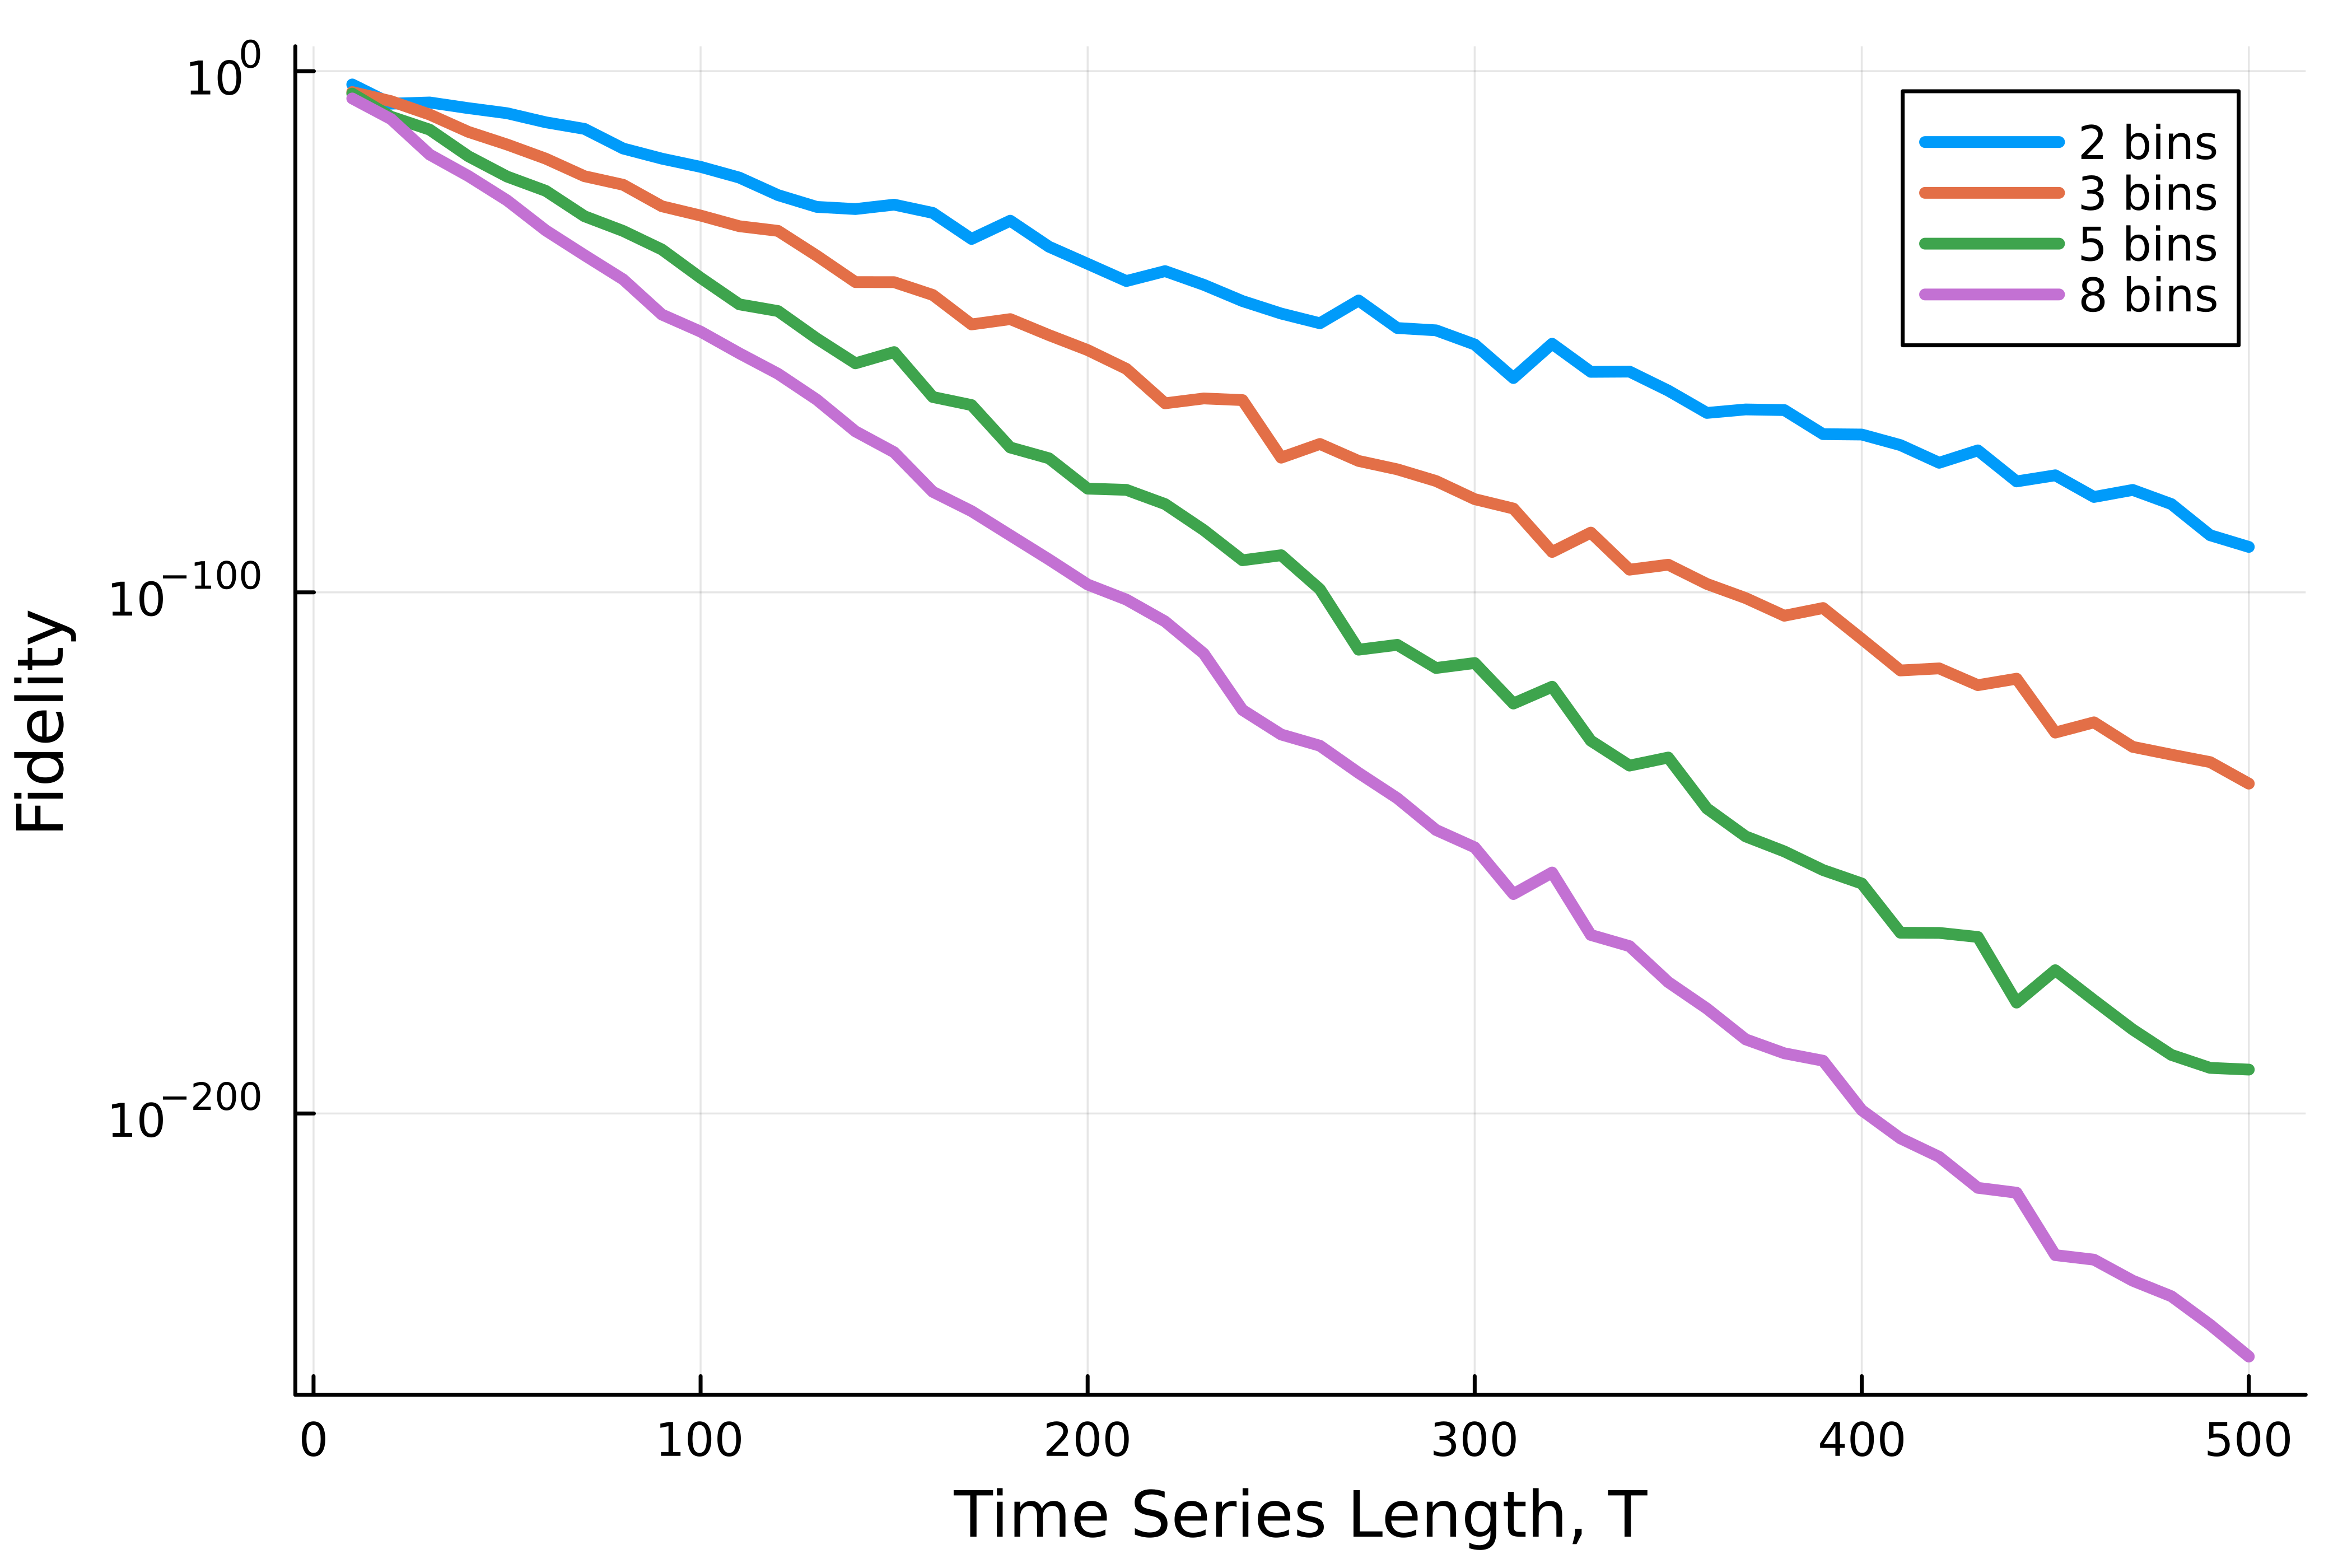

In [114]:
plot(T, overlap_per_d[1], lw=3, yscale=:log10, label="2 bins", dpi=700)
plot!(T, overlap_per_d[2], lw=3, yscale=:log10, label="3 bins")
plot!(T, overlap_per_d[3], lw=3, yscale=:log10, label="5 bins")
plot!(T, overlap_per_d[4], lw=3, yscale=:log10, label="8 bins")
xlabel!("Time Series Length, T")
ylabel!("Fidelity")
#savefig("fidelity_scaling.png")

Convert model output to probability - let's start by computing the overlap between the MPS and a product state.

In [13]:
output = 1
for i=1:50
    output *= W[i] * ϕs[1][i]
end

In [30]:
function modelProbability(y::ITensor)
    norm_val = (y*y)[]
    return [y[i]^2 / norm_val for i in 1:ITensors.dim(y)]
end;

In [31]:
modelProbability(output)

2-element Vector{Float64}:
 0.9921905763077984
 0.007809423692201545

In [193]:
inds(output)[1]

(dim=2|id=215|"f(x)")

In [195]:
label_idx = inds(output)[1]
y = onehot(label_idx => 1)

ITensor ord=1 (dim=2|id=215|"f(x)")
NDTensors.Dense{Float64, Vector{Float64}}

In [50]:
function Loss(W, ϕ)
    output = 1
    for i=1:50
        output *= W[i] * ϕ[i]
    end
    fake_label = 1
    y_hat = output
    label_idx = inds(output)[1]
    y = onehot(label_idx => fake_label)
    y_yhat = (y_hat * y)[] # select the entry corresp to the ground truth
    prob = y_yhat^2 / (y_hat*y_hat)[] # convert to proability by squaring and dividing through by normalisation factor
    
    correct = 0
    model_proba = modelProbability(y_hat)
    if (argmax(model_proba) - 1) == fake_label
        correct = 1
    end
    return [-log(prob), correct]
end

Loss (generic function with 1 method)

Consider just sites 1 and 2:

In [56]:
B = W[1] * W[2]

ITensor ord=4 (dim=3|id=212|"Qudit,Site,n=1") (dim=2|id=513|"f(x)") (dim=3|id=653|"Qudit,Site,n=2") (dim=5|id=496|"Link,l=2")
NDTensors.Dense{Float64, Vector{Float64}}

In [60]:
B2 = B * ϕs[1][1] * ϕs[1][2]

ITensor ord=2 (dim=2|id=513|"f(x)") (dim=5|id=496|"Link,l=2")
NDTensors.Dense{Float64, Vector{Float64}}

In [61]:
RE = 1
for i=3:50
    RE *= W[i] * ϕs[1][i]
end

In [62]:
RE

ITensor ord=1 (dim=5|id=496|"Link,l=2")
NDTensors.Dense{Float64, Vector{Float64}}

In [63]:
B3 = B2 * RE

ITensor ord=1 (dim=2|id=513|"f(x)")
NDTensors.Dense{Float64, Vector{Float64}}

Obtain decision function output

In [64]:
@show B3

B3 = ITensor ord=1
Dim 1: (dim=2|id=513|"f(x)")
NDTensors.Dense{Float64, Vector{Float64}}
 2-element
 2.6816049525466157e-14
 2.3790673834528772e-15


ITensor ord=1 (dim=2|id=513|"f(x)")
NDTensors.Dense{Float64, Vector{Float64}}

In [65]:
yhat = B3

ITensor ord=1 (dim=2|id=513|"f(x)")
NDTensors.Dense{Float64, Vector{Float64}}

In [66]:
deriv = RE * ϕs[1][1] * ϕs[1][2]

ITensor ord=3 (dim=5|id=496|"Link,l=2") (dim=3|id=212|"Qudit,Site,n=1") (dim=3|id=653|"Qudit,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}

Compute gradient

In [67]:
y_hat = yhat
d_yhat_dW = deriv

ITensor ord=3 (dim=5|id=496|"Link,l=2") (dim=3|id=212|"Qudit,Site,n=1") (dim=3|id=653|"Qudit,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}

Make target output

In [73]:
y = onehot(inds(y_hat)[1] => 1)
@show y

y = ITensor ord=1
Dim 1: (dim=2|id=513|"f(x)")
NDTensors.Dense{Float64, Vector{Float64}}
 2-element
 1.0
 0.0


ITensor ord=1 (dim=2|id=513|"f(x)")
NDTensors.Dense{Float64, Vector{Float64}}

In [74]:
y_yhat = (y * y_hat)[] # isolate the ground truth label index

2.6816049525466157e-14

In [75]:
yhat_yhat = (y_hat * y_hat)[] # get norm factor

7.24760473767263e-28

Convert to probability

In [76]:
p = y_yhat^2 / yhat_yhat

0.9921905763077985

In [77]:
loss = -log(p)

0.007840076935137977

Construct gradient

In [78]:
first_half = y_yhat * (y * d_yhat_dW)
first_half ./= yhat_yhat

ITensor ord=4 (dim=2|id=513|"f(x)") (dim=5|id=496|"Link,l=2") (dim=3|id=212|"Qudit,Site,n=1") (dim=3|id=653|"Qudit,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}

In [80]:
second_half = y_yhat^2 * (y_hat * d_yhat_dW)
second_half ./= (yhat_yhat)^2

ITensor ord=4 (dim=2|id=513|"f(x)") (dim=5|id=496|"Link,l=2") (dim=3|id=212|"Qudit,Site,n=1") (dim=3|id=653|"Qudit,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}

In [81]:
grad = -2 * (first_half - second_half)
grad ./= p

ITensor ord=4 (dim=2|id=513|"f(x)") (dim=5|id=496|"Link,l=2") (dim=3|id=212|"Qudit,Site,n=1") (dim=3|id=653|"Qudit,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}

In [82]:
@show grad

grad = ITensor ord=4
Dim 1: (dim=2|id=513|"f(x)")
Dim 2: (dim=5|id=496|"Link,l=2")
Dim 3: (dim=3|id=212|"Qudit,Site,n=1")
Dim 4: (dim=3|id=653|"Qudit,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}
 2×5×3×3
[:, :, 1, 1] =
 -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0

[:, :, 2, 1] =
 -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0

[:, :, 3, 1] =
 -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0

[:, :, 1, 2] =
 -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0

[:, :, 2, 2] =
 -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0

[:, :, 3, 2] =
 -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0

[:, :, 1, 3] =
 -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0

[:, :, 2, 3] =
  0.054450811973181294  -0.04040583192129474  -0.0014142648754588572   0.06661337741304846  -0.021756632453188852
 -0.6137512878914245     0.45544098391469023   0.01594111928321645    -0.7508436457879303    0.24523346309145727

[:, :, 3, 3] 

ITensor ord=4 (dim=2|id=513|"f(x)") (dim=5|id=496|"Link,l=2") (dim=3|id=212|"Qudit,Site,n=1") (dim=3|id=653|"Qudit,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}